In [18]:
import os
import time
import pandas as pd
import numpy as np
import xarray as xr
import xradar as xd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.io.img_tiles import GoogleTiles
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from glob import glob
from IPython.display import HTML
import warnings
import pyart
warnings.simplefilter("ignore")

def fix_angle(ds):
    '''
    Preprocessing function to align angles of different radar volumes
    '''
    ds["time"] = ds.time.load()
    start_ang = 0
    stop_ang = 360
    angle_res = ds.azimuth.diff("azimuth").median()
    median_diff = ds.azimuth.diff("time").median()
    ascending = median_diff > 0
    direction = 1 if ascending else -1

    ds = xd.util.remove_duplicate_rays(ds)
    ds = xd.util.reindex_angle(ds, start_ang, stop_ang, angle_res, direction, method="nearest")
    ds = ds.expand_dims("volume_time")
    ds["volume_time"] = [np.nanmin(ds.time.values)]
    return ds

def read_data(files, sweep):
    '''
    Read files and output xarray dataframe.
    Input: path or list of paths, sweep (eg 'sweep_0')
    '''
    ds = xr.open_mfdataset(
        files,
        #drop_variables=DROP_VARS,
        engine="cfradial1",
        preprocess=fix_angle,
        group=sweep,
        concat_dim="volume_time",
        combine="nested",
    )

    ds = ds.xradar.georeference()
    return ds

def plot_range_rings(range_rings_in_km, ax, loc, plot_crs):
    '''
    Add range rings to plot and label 
    Input: range rings in km from radar, plot axes, location of labels in degrees, map projection
    '''
    loc_r = np.radians(loc)
    transform = plot_crs
    for ring in range_rings_in_km:
        angle = np.linspace(0., 2.0 * np.pi, 360)
        mask_angle = 22 / ring
        
        for i in range(len(angle)):
            if loc_r - (mask_angle / 2) <= angle[i] <= loc_r + (mask_angle / 2):
                angle[i] = np.nan 
        
        label = f"{ring} km"
        xpts = ring * 1000. * np.sin(angle)
        ypts = ring * 1000. * np.cos(angle)
        rot = 360 - loc
        ax.plot(xpts, ypts, linestyle='-', c='black', linewidth=0.6, transform=transform, zorder=9, alpha=0.6)
        txt = ax.text(ring * 1000 * np.sin(loc_r), ring * 1000 * np.cos(loc_r), label, va='center', ha='center',
                      fontsize=8, alpha=0.7, color='black', clip_on=True, transform=transform, rotation=rot)
        txt.clipbox = ax.bbox
    
def create_plot(data):
    '''
    create one plot, if multiple files have been read this will plot the first volume time
    Input: xarray dataframe
    '''
    ds = data
    # set map projection
    plot_crs = ccrs.AzimuthalEquidistant(central_longitude=ds.longitude.values, central_latitude=ds.latitude.values)

    # create figure
    fig, ax = plt.subplots(figsize=(5.8, 5), subplot_kw={"projection": plot_crs}, dpi = 100)

    # add terrain
    terrain_tile = GoogleTiles(url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')
    ax.add_image(terrain_tile, 10)

    #plot first timestep 
    if len(list(ds.dims)) > 2:
        plt_data = ds.isel(volume_time=0)
    else:
        plt_data = ds

    sc = plt_data.dBZ.plot.pcolormesh(
        x="x",
        y="y",
        vmin=-20,
        vmax=50,
        #extend='both',
        cmap="pyart_HomeyerRainbow",
        edgecolors="None",
        transform=plot_crs,
        ax=ax,
        rasterized=True,
        add_colorbar=False
        )

    # add colorbar
    cax = inset_axes(ax, width="3.75%", height="97.7%", loc='lower left', bbox_to_anchor=(1.02, -0.01, 1, 1),
                     bbox_transform=ax.transAxes)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', extend='both')
    cbar.ax.tick_params(axis='y', direction='in', pad=2, width=0.75, length=5)
    cbar.set_label('Reflectivity [dBZ]', fontsize=10, rotation=270, labelpad=10)

    # set up titles
    if scan_type == 'bl_scans':
        scan = 'BL'
    else:
        scan = 'Cloud'
        
    date_str = str(pd.to_datetime(ds.volume_time.values[0]).date())
    time_str = str(pd.to_datetime(ds.volume_time.values[0]).time())
    time_title = '$\\bf{Date:}$ ' + date_str + '\n' + '$\\bf{Time:}$ ' + time_str

    ele = ds.elevation.values[0]
    radar_title = '$\\bf{Radar:}$ ' + radar + '\n' + '$\\bf{Scan:}$ ' + f'{scan} {ele}°'

    ax.set_title('')
    ax.set_title(time_title, loc='left', fontsize=10)
    ax.set_title(radar_title, loc='right', fontsize=10)

    # add gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        rotate_labels=False,
        linewidth=0.75,
        color="gray",
        alpha=0.3,
        linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False

    # add grid lines and calculate extent
    range_rings = [50, 100]
    plot_range_rings(range_rings, ax, 45, plot_crs)

    r = 100
    min_lat = ds.latitude.values - (r / 6378) * (180 / np.pi) - 0.025
    max_lat = ds.latitude.values + (r / 6378) * (180 / np.pi) + 0.01
    min_lon = ds.longitude.values - (r / 6378) * (180 / np.pi) / np.cos(ds.latitude.values * np.pi / 180)
    max_lon = ds.longitude.values + (r / 6378) * (180 / np.pi) / np.cos(ds.latitude.values * np.pi / 180)

    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Markers for radar locations
    radar_locations = {'NX-1': (-2.00547, 51.5071), 'NX-2': (-1.438358, 51.144981)}
    for loc, (lon, lat) in radar_locations.items():
        ax.plot(lon, lat, marker='o', markersize=3, color='k', transform=ccrs.PlateCarree(), zorder=500)
        ax.annotate(loc, (lon + 0.015, lat + 0.015), transform=ccrs.PlateCarree(), fontsize=8)

    fig.subplots_adjust(left=0.07, bottom=0.07, right=0.9, top=0.9)
    return fig, ax, sc

def update_plot(i, plot_array, ds, ax):
    '''
    update data on plot when creating animation
    '''
    plot_array.set_array(ds.isel(volume_time=i).dBZ.values.ravel())
    time_str = str(pd.to_datetime(ds.volume_time.values[i]).time())
    date_str = str(pd.to_datetime(ds.volume_time.values[0]).date())
    time_title = '$\\bf{Date:}$ ' + date_str + '\n' + '$\\bf{Time:}$ ' + time_str
    ax.set_title(time_title, loc='left', fontsize=10)

def create_animation(files, radar, date, scan_type, sweep):
    data = read_data(files, sweep)
    fig, ax, plot_array = create_plot(data)
    
    anim = FuncAnimation(fig, update_plot, fargs=(plot_array, data, ax), frames=len(files), save_count = len(files), interval=250)
    
    outpath = f'/home/users/eeslb/woest/plots/radar_videos/{radar}/{date}_{radar}_{scan_type}_{sweep}_dBZ.mp4'
    writervideo = animation.FFMpegWriter(fps=3) 
    anim.save(outpath, writer=writervideo, dpi = 200)
    
    plt.close()
    data.close()

    #return HTML(anim.to_html5_video())

In [39]:
dates = ['20230612','20230620','20230621','20230622','20230803','20230809','20230810','20230814','20230818','20230825']

for date in dates:
    radar = 'NXPol-1'
    scan_type = 'bl_scans'
    sweep = 'sweep_0'
    
    if radar == 'NXPol-1':
        directory = '/gws/pw/j07/woest/data/ncas-mobile-x-band-radar-1//level2/sur/'
    elif radar == 'NXPol-2':
        directory = '/gws/pw/j07/woest/data/ncas-radar-x-band-2/level2/sur/'
    else:
        print('no radar')

    outpath = f'/home/users/eeslb/woest/plots/radar_videos/{radar}/{date}_{radar}_{scan_type}_{sweep}_dBZ.mp4'
    if os.path.exists(outpath):
        print('file exists')
    else:
        files = glob(os.path.join(directory, date, scan_type, '**'))
        create_animation(files, radar, date, scan_type, sweep)

file exists
file exists
file exists
file exists
file exists
file exists
file exists


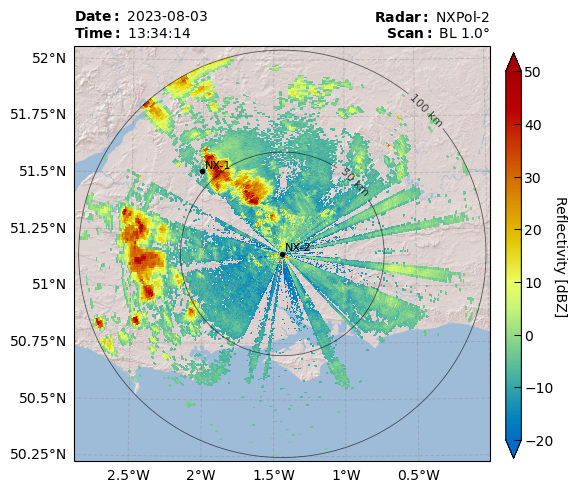

In [24]:
radar = 'NXPol-2'
date = '20230803'
scan_type = 'bl_scans'
sweep = 'sweep_0'

if radar == 'NXPol-1':
    directory = '/gws/pw/j07/woest/data/ncas-mobile-x-band-radar-1//level2/sur/'
elif radar == 'NXPol-2':
    directory = '/gws/pw/j07/woest/data/ncas-radar-x-band-2/level2/sur/'
else:
    print('no radar')

files = glob(os.path.join(directory, date, scan_type, '**'))
data = read_data(files[80], sweep)

# select data, and then create plot 
create_plot(data);

In [29]:
data.dBZ.load().max()

<xarray.DataArray 'dBZ' ()> Size: 8B
array(54.29999924)
Coordinates:
    latitude   float64 8B 51.15
    longitude  float64 8B -1.439
    altitude   float64 8B 88.4
    crs_wkt    int64 8B 0